In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
import os
import random
import csv
from IPython.core.display import HTML
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average



def load_data(filePath):
    #loads csv file into data frame and returns the data frame
    df = pd.DataFrame.from_csv(filePath)
    #unindex GameId
    df = df.reset_index('GameId')
    return df



def preprocess_data(df):
    '''This function will apply preprocessing steps to the initial data frame'''
    
    #sort the data frame so all games are in order
    df = df.sort_values(by = ['GameId', 'Quarter', 'Minute', 'Second'], ascending = [True, True, False, False])
    
    #we only want plays that are RUSH or PASS for purposes of prediction
    df_subset = df[np.logical_or(df.PlayType == 'RUSH', df.PlayType == 'PASS')]
    
    #subset of the data that we believe will be important for our prediction problem
    df_final = df_subset[['OffenseTeam', 'DefenseTeam', 'Down', 'ToGo'
                      , 'YardLine', 'YardLineDirection', 'Quarter', 'Minute', 'Second','Formation', 'PlayType']]
    
    #get rid of rows that have NaN's in any columns
    df_final = df_final.dropna()
    
    #create a label encoding column in the dataframe for PlayType since it is the variable we are trying to predict
    df_final.PlayType = df_final.PlayType.astype('category')
    df_final['PlayType_cat'] = df_final.PlayType.cat.codes
    
    #create dummy variables for each feature that is categorical
    #(OffenseTeam, DefenseTeam, YardLineDirection, and Formation)
    df_final = pd.get_dummies(df_final, columns = ['OffenseTeam', 'DefenseTeam', 'YardLineDirection', 'Formation'])
    
    return df_final


def round_array(array):
    '''return a list of floats that have been rounded from given array'''
    lst_to_return = []
    for entry in array:
        lst_to_return.append(round(entry))
    return lst_to_return



def build_model(df, year):
    
    #create a train and test set
    x_train, x_test, y_train, y_test = train_test_split(df_final.drop(labels = ['PlayType', 'PlayType_cat'], axis = 1).values, 
                                              df_final.PlayType_cat.values, random_state = 69)
    
    #fit a logistic regression model
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    
    #accuracy score on train data
    train_accuracy_score_no_grid = accuracy_score(clf.predict(x_train), y_train)
    
    #accuracy score on test data
    test_accuracy_score_no_grid = accuracy_score(clf.predict(x_test), y_test)
    
    #5 Fold Cross Validation Accuracy
    five_fold_cv_score_no_grid = cv_score(clf, x_train, y_train)
    
    #the grid of parameters to search over
    Cs = [0.001, 0.1, 1, 10, 100]
    param_grid = {'C' : Cs }
    model = GridSearchCV(LogisticRegression(), param_grid, scoring = 'accuracy', cv = 5)
    model.fit(x_train, y_train)
    
    #best regularization parameter from grid search
    best_reg = model.best_params_['C']
    
    #test set accuracy with the best regularization parameter
    test_accuracy_best_reg = accuracy_score(model.predict(x_test), y_test)
    
    #gather model metrics using the best regularization parameter
    preds = model.predict_proba(x_test)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    y_test_rounded = round_array(y_test)
    preds_rounded = round_array(preds)

    #precision (true positives / [true positives + false positives])
    precision = metrics.precision_score(y_test_rounded, preds_rounded)

    #recall (true positives / [true positives + false negatives])
    recall = metrics.recall_score(y_test_rounded, preds_rounded)

    #F1 score is the geometric/harmonic mean of precision and recall; 2 * tp / ( 2 * tp + fp + fn)
    f1_score = metrics.f1_score(y_test_rounded, preds_rounded)
    
    #AUC
    auc = metrics.auc(fpr, tpr)
    
    #list of metrics
    metrics_lst = [
        year,
        train_accuracy_score_no_grid,
        test_accuracy_score_no_grid,
        five_fold_cv_score_no_grid,
        best_reg,
        test_accuracy_best_reg,
        precision,
        recall,
        f1_score,
        auc
    ]
    
    #rates to make ROC curve
    roc_curve_metrics = [year, fpr, tpr, auc]
    
    lst_to_return = [metrics_lst, roc_curve_metrics]
    
    return lst_to_return

In [3]:
years = [2014, 2015, 2016]
metrics_lsts = [] #will hold all the metrics data
roc_curve_rates = [] #will hold fpr & tpr to build ROC curve
metrics_csv_file_path = 'C:\\Users\\abird\\Documents\\Springboard\\Capstone Project\\NFL\\all_data_model_metrics.csv'

columns = [
        'season',
        'train_accuracy_score_no_grid',
        'test_accuracy_score_no_grid',
        'five_fold_cv_score_no_grid',
        'best_reg',
        'test_accuracy_best_reg',
        'precision',
        'recall',
        'f1_score',
        'auc'
    ]

for year in years:
    filePath = 'C:\\Users\\abird\\Documents\\Springboard\\Capstone Project\\NFL\\pbp-' + str(year) + '.csv'
    df = load_data(filePath)
    df_final = preprocess_data(df)
    
    #each year's metrics results will be held in metrics_lst, tpr & fpr are used for ROC Curve
    metrics_lst, roc_curve_metrics = build_model(df_final, year)
    metrics_lsts.append(metrics_lst)
    roc_curve_rates.append(roc_curve_metrics)
    
#convert metrics_lsts into a dataframe
metrics_df = pd.DataFrame(metrics_lsts, columns = columns)

In [4]:
metrics_df

,season,train_accuracy_score_no_grid,test_accuracy_score_no_grid,five_fold_cv_score_no_grid,best_reg,test_accuracy_best_reg,precision,recall,f1_score,auc
0,2014,0.722887,0.737108,0.722339,1,0.737108,0.683570,0.638661,0.660353,0.789089
1,2015,0.743740,0.742037,0.741858,10,0.742287,0.668842,0.640882,0.654564,0.794244
2,2016,0.735604,0.731133,0.735100,1,0.731133,0.668056,0.620245,0.643263,0.779077


**write metrics_df into a csv file**

In [5]:
metrics_df.to_csv(metrics_csv_file_path)

*ROC Curves*

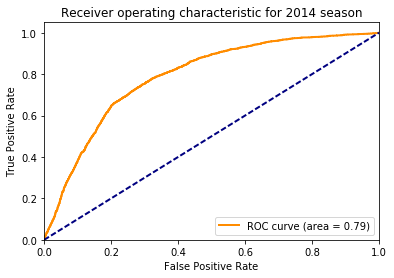

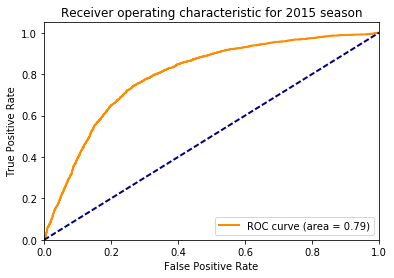

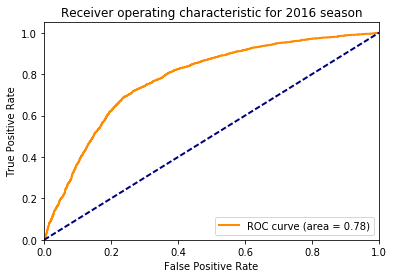

In [6]:
#generates ROC curve for each season
for roc_curve_rate in roc_curve_rates:
    #extract metrics from list
    year, fpr, tpr, auc = roc_curve_rate
    plt.figure()
    title = 'Receiver operating characteristic for ' + str(year) + ' season'
    lw = 2
    plt.plot(fpr, tpr, color = 'darkorange',
             lw = lw, label = 'ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()